# Calculation of the SNB heat flux

Import all needed libraries

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import Boltzmann as kb, epsilon_0 as ep0
from scipy.constants import elementary_charge as qe, electron_mass as me
from scipy.linalg import solve_banded
import warnings
warnings.filterwarnings('ignore')

Determine the functions to calculate heat fluxes

In [11]:
# Thomas algorithm
def thomas(a, b, c, d):
    ac = np.copy(a)
    bc = np.copy(b)
    cc = np.copy(c)
    dc = np.copy(d)
    x = np.zeros(a.size)
    for i in np.arange(1, a.size):
        tmp = ac[i] / bc[i-1]
        bc[i] -= tmp * cc[i-1]
        dc[i] -= tmp * dc[i-1]

    x[-1] = dc[-1] / bc[-1]
    for i in np.arange(a.size-2, -1, -1):
        x[i] = (dc[i] - cc[i] * x[i+1]) / bc[i]
    return x


def snb(T0, n0):
    # Plasma parameters
    n_e = 0.5 * n0

    # Set up grid
    Nx = 100
    xmax = 25e6
    xmin = -xmax

    dx = (xmax - xmin) / Nx
    x_grid_b = np.linspace(xmin, xmax, Nx+1)
    x_grid_c = 0.5 * (x_grid_b[1:] + x_grid_b[:-1])

    # Initial temperature profile
    T0 = T0  # Kelvin
    T_max = T0 * 0.01
    T_scale = 5e6
    Te_c = T0  + T_max * np.exp(-(x_grid_c / T_scale)**2)
    Te_b = T0  + T_max * np.exp(-(x_grid_b / T_scale)**2)
    
    # Set up energy groups for SNB
    ng = 50
    emin = 0.0
    # Max energy group 
    emax = 20 * T0  # Kelvin

    e_grid_b = np.linspace(emin, emax, ng+1)
    e_grid_c = 0.5 * (e_grid_b[1:] + e_grid_b[:-1])

    # Calculate thermal speed and Spitzer Harm conductivity
    vt_b = np.sqrt(2 * kb * Te_b / me)
    # Common solar SH approximation
    kappa_SH_b = 1.e-11 * Te_b**2.5

    # Zero flux at boundaries
    grad_T_b = np.concatenate(
        [np.zeros(1), (Te_c[1:] - Te_c[:-1]) / dx, np.zeros(1)])

    # Spitzer Harm heat flux
    Q_SH_B = -grad_T_b * kappa_SH_b

    # Source term for SNB energy groups
    source_term = np.zeros([Nx, ng])

    # Weights for SNB groups
    weight = np.zeros([Nx+1, ng])

    def weight_fn(x):
        return - np.exp(-x) * (x**4 + 4.0 * x**3 + 12 * x**2 + 24 * x + 24)

    for i in range(ng):
        xm = e_grid_b[i] / Te_b[:]
        x = e_grid_b[i+1] / Te_b[:]
        weight[:, i] = (weight_fn(x) - weight_fn(xm)) / 24

    # Now set up source term
    for i in range(ng):
        div_Ug = (Q_SH_B[1:] * weight[1:, i] -
                  Q_SH_B[:-1] * weight[:-1, i]) / dx
        source_term[:, i] = -div_Ug * dx**2

    # Now need so solve for corrected flux
    H_g = np.zeros([Nx, ng])
    grad_H_g = np.zeros([Nx+1, ng])

    a = np.zeros(Nx)
    b = np.zeros(Nx)
    c = np.zeros(Nx)

    # Simple mfp from (Arber et al. 2023)
    lambda_e_b = 5.5e7 * Te_b**2 / n_e

    lambda_g_b = np.zeros([Nx+1, ng])
    lambda_g_c = np.zeros([Nx, ng])

    for i in range(ng):
        lambda_g_b[:, i] = lambda_e_b * (e_grid_c[i] / Te_b)**2 

    lambda_g_c = 0.5 * (lambda_g_b[1:] + lambda_g_b[:-1])

    # Solve linear systems
    for i in range(ng):
        a = - lambda_g_b[1:, i] / 3.0
        c = - lambda_g_b[0:-1, i] / 3.0
        b = dx**2 / lambda_g_c[:, i]       
        b = b - a - c
        
        H_g = thomas(a, b, c, source_term[:, i])
        grad_H_g[1:-1, i] = (H_g[1:] - H_g[:-1]) / dx

    grad_H = np.sum(grad_H_g * lambda_g_b, axis=1) / 3

    # Resulting SHB heat flux
    Q_SNB = Q_SH_B - grad_H

    # FL heat flux
    alpha = 0.0005 # flux limiter value
    q_fs =  n_e * vt_b * kb * Te_b
    q_fs_l = alpha * q_fs
    Q_lim_l =  q_fs_l * Q_SH_B / np.sqrt(abs(Q_SH_B)**2 + q_fs_l**2)

    return (x_grid_b / 1e6, Q_SH_B, Q_SNB, Q_lim_l, Te_b, q_fs)

Calculate heat fluxes

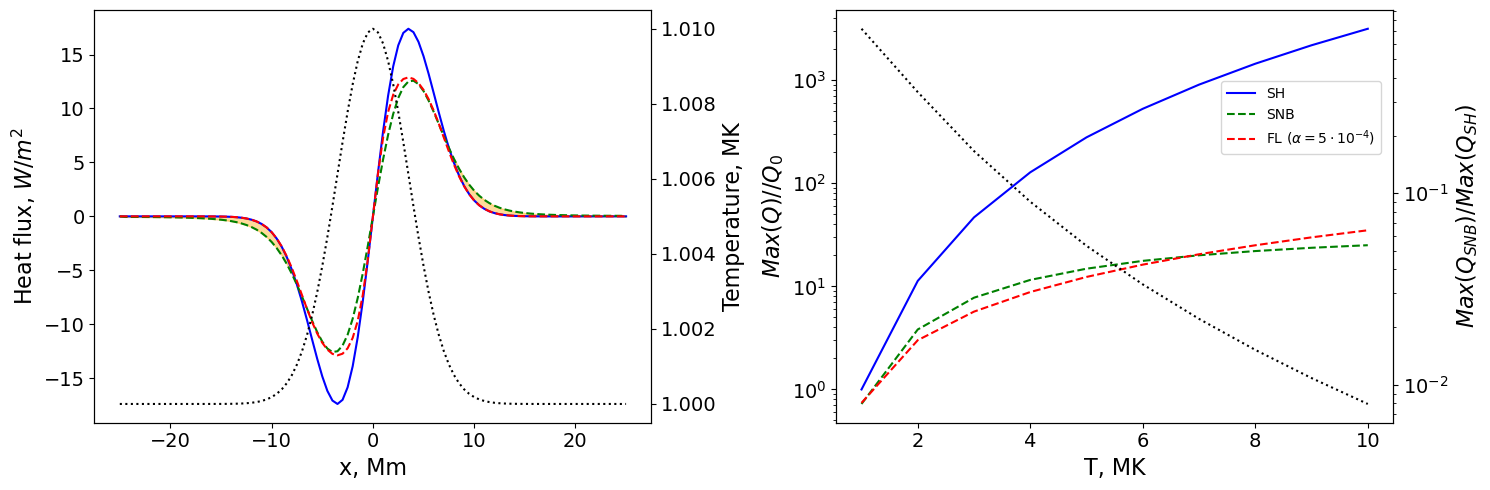

In [15]:
# Plasma temperature and number density (ions + electrons)
T0 = 1e6 # MK
n0 = 1e15 # 1/m^3


fig, axs = plt.subplots(1, 2, figsize=(15,5))

# Plot heat fluxes
ax = axs[0]

x, Q_SH_B, Q_SNB, Q_lim_l, Te, _ = snb(T0, n0)

ax.plot(x, Q_SH_B, label=rf"SH", linestyle='solid', color='blue')
ax.plot(x, Q_SNB, label=rf"SNB", linestyle='dashed', color='green')
ax.plot(x, Q_lim_l, label=r"FL $\left(\alpha=5\cdot10^{-4}\right)$", linestyle='dashed', color='red')

# Highlight the preeating region
x_p = x[np.abs((Q_SNB - Q_SH_B)/Q_SH_B)< 1e-2]
x_l = x_p[0]
x_r = x_p[-1]
ax.fill_between(x[x<x_l], Q_SH_B[x<x_l], Q_SNB[x<x_l], alpha=0.4, color='orange')
ax.fill_between(x[x>x_r], Q_SH_B[x>x_r], Q_SNB[x>x_r], alpha=0.4, color='orange')

ax.set_xlabel('x, Mm', fontsize=16)
ax.set_ylabel(r'Heat flux, $W/m^{2}$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)

# Plot temperature perturbation
ax = ax.twinx()
ax.plot(x, Te/1e6, linestyle='dotted', color='black')
ax.set_ylabel(r'Temperature, MK', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)

# Plot dependence of maximum heat flux on temperture
ax = axs[1]
q_sh = []
q_fs = []
q_snb = []
q_fl = []

Ts = np.arange(1e6, 10e6 + 1, 1e6)
for T0 in Ts:
    x, Q_SH_B, Q_SNB, Q_lim_l, _ ,Q_FS = snb(T0, n0)
    q_sh.append(Q_SH_B.max())
    q_fs.append(Q_FS.max())
    q_fl.append(Q_lim_l.max())
    q_snb.append(Q_SNB.max())

# We measure heat flux in units of heat flux at minimal temperature
scale = q_sh[0]
ax.plot(Ts/1e6, np.array(q_sh)/scale,  label=rf"SH", linestyle='solid', color='blue')
ax.plot(Ts/1e6, np.array(q_snb)/scale,label=rf"SNB", linestyle='dashed', color='green')
ax.plot(Ts/1e6, np.array(q_fl)/scale, label=r"FL $\left(\alpha=5\cdot10^{-4}\right)$", linestyle='dashed', color='red')

label=r"$Max\left(Q\right)//Q_0$"
ax.set_xlabel('T, MK', fontsize=16)
ax.set_ylabel(label, fontsize=16)
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(loc='center right', bbox_to_anchor=(0.99,0.74))

# Plot relation between SNB and SH fluxes
ax = ax.twinx()
scale = q_sh
ax.plot(Ts/1e6, np.array(q_snb)/scale, linestyle='dotted', color='black')

label=r"$Max\left(Q_{SNB}\right)/Max\left(Q_{SH}\right)$"
ax.set_xlabel('T, MK', fontsize=16)
ax.set_ylabel(label, fontsize=16)
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=14)

fig.tight_layout()


fig.savefig(f'./fluxes.pdf')